# Poisson Problem

In [21]:
# import scipy as sp
import random
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from mud.base import SpatioTemporalProblem
from mud.plot import plot_vert_line, save_figure, plot_1D_vecs
from scipy.interpolate import interp1d
from scipy.optimize import minimize

__author__ = "Carlos del-Castillo-Negrete"
__copyright__ = "Carlos del-Castillo-Negrete"
__license__ = "mit"

# Matplotlib plotting options
plt.backend = "Agg"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.size"] = 16
plt.rcParams["text.usetex"] = True
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{bm} \usepackage{amsfonts} \usepackage{amsmath}"
plt.rcParams["savefig.facecolor"] = "white"

plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.titlesize"] = 26
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

In [2]:
figs = {}
save_figs = False  # True
save_dir = "."
resolution = 250

In [3]:
if not save_figs:
    %matplotlib widget

# Functions

## Loading Datasets for Poisson Problem

Loads dataset in pickled file, with appropriate data. Creates model data by plotting true solution with noise. 

In [4]:
def load_poisson_prob(
    prob_data_file,
    std_dev=0.05,
    seed=21,
):
    """
    Load Poisson Problem Dataset


    Parameters
    ----------
    prob_data_file : pathlib.Path, str
        Path to pickled data file storing data from solving poisson problem.
    std_dev : float, default = 0.05
        Standard deviation of noise to add to true values stored in dataset
        to create fake "measurements".
    seed : int, default = 21
        For reproducbile results, leave seed as is or set to a value. Otherwise,
        set to None.

    Returns
    -------
    data, poisson_prob : Tuple(dict, mud.base.SpatioTemporalProblem)
        Returns a pair of the raw dictionary loaded from the pickled dataset
        and the associated SpatioTemporalProblem class object associated with it.
    """

    poisson_prob = SpatioTemporalProblem()
    data = poisson_prob.load(
        str(prob_data_file),
        lam="lam",
        data="data",
        true_vals="true_vals",
        measurements=None,
        std_dev=0.05,
        sample_dist="uniform",
        domain="domain",
        lam_ref=None,
        sensors="sensors",
        times=None,
    )

    poisson_prob.measurements_from_reference(std_dev=0.05, seed=seed)

    return data, poisson_prob

## Running Trials for increasing number of sensors

Using an existing data set, run trials solving using increasing number of sensors

In [5]:
def poisson_run_trials(
    dataset_path: str,
    sensors: List[int] = [5, 10, 50],
    num_trials: int = 20,
    std_dev: float = 0.05,
):
    """
    Runs problems for Poisson problem described in 7.1
    """

    poisson_prob = SpatioTemporalProblem()
    poisson_prob.load(
        dataset_path,
        lam="lam",
        data="data",
        true_vals="true_vals",
        measurements=None,
        std_dev=std_dev,
        sample_dist="uniform",
        domain="domain",
        lam_ref=None,
        sensors="sensors",
        times=None,
    )

    all_sensors_idx = random.sample(range(poisson_prob.n_sensors), sensors[-1])
    num_epochs = len(sensors)

    info = []
    probs = []
    qoi_pca = np.zeros((num_trials * num_epochs, poisson_prob.n_samples, 2))
    for idx, ns in enumerate(sensors):
        sensors_idx = all_sensors_idx[0:ns]
        trials = []
        for i in range(num_trials):
            poisson_prob.measurements_from_reference(std_dev=0.05)
            lam_best = poisson_prob.get_closest_to_measurements(sensors_idx=sensors_idx)

            mud_prob = poisson_prob.mud_problem(
                method="pca", num_components=2, sensors_idx=sensors_idx
            )
            mud_pt = qpca_mud_prob.estimate()

            # Store error, exp_r and qoi_pca data
            info.append(
                [
                    "pca",
                    ns,
                    i,
                    pca_pt[0],
                    pca_pt[1],
                    np.linalg.norm(qpca_mud_prob.estimate() - lam_best),
                    qpca_mud_prob.exp_r(),
                ]
            )
            qoi_pca[idx * len(sensors) + i, :, :] = qpca_mud_prob.y
            trials.append((qwme_mud_prob, qpca_mud_prob, map_prob))

        # Collect all mud problems
        probs.append(trials)

    info = pd.DataFrame(
        info, columns=["type", "n", "i", "lam_1", "lam_2", "err", "exp_r"]
    )

    return (probs, info)

## Plotting Solution Splines

Plotting solution $g(x)$ as represented by our parametrized linear spline.

In [6]:
def plot_solution_spline(lam, aff=1000, plot_true=True, ax=None, **kwargs):
    """Plot data for reference solution


    Parameters
    ----------
    data_file: str, optional
        Path to pickle file containing plot values of true boundary function
        $g(x_2) \propto x_2^2(x_2-1)^5$, min at $(2/7, -3)$.

    """

    if ax is None:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(1, 1, 1)

    if plot_true:
        x = np.linspace(0, 1, aff)
        a = 197.65032
        g = a * np.power(x, 2) * np.power((x - 1), 5)
        ax.plot(x, g, lw=5, c="k", label="$g$")

    intervals = list(np.linspace(0, 1, 2 + len(lam))[1:-1])
    ax.plot([0] + intervals + [1], [0] + list(lam) + [0], **kwargs)

    ax.set_xlabel("$x_2$")
    ax.set_ylabel("$g(x_2,\lambda)$")
    ax.set_xlim([0, 1])
    ax.set_ylim([-4, 0])

    return ax

### Computing optimal solution spline


In [7]:
def spline_objective_function_2d(lam, aff=10000):
    """objective function to optimize
    Parameters
    ----------
    lam1: float
        $lambda_1$ parameter value - location of first knot at x=1/3.
    lam2: float
        $lambda_2$ parameter value - location of second knotnot at x=2/3.

    """
    x = np.linspace(0, 1, aff)
    a = 197.65032
    g = a * np.power(x, 2) * np.power((x - 1), 5)
    spline = interp1d([0, 1 / 3, 2 / 3, 1], [0, lam[0], lam[1], 0])
    vals = spline(x)

    return np.linalg.norm(g - vals)

# Two Dim Solution

## Computing Closest Spline

Using SciPy Optimize

In [8]:
res = minimize(spline_objective_function_2d, x0=[-3, -1])
res

      fun: 23.949187153799905
 hess_inv: array([[ 0.01162731, -0.00283682],
       [-0.00283682,  0.01150357]])
      jac: array([-4.76837158e-07, -7.15255737e-07])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([-3.35980144, -0.09123589])

In [9]:
closest = res["x"]
closest

array([-3.35980144, -0.09123589])

## Loading Poisson Prob Data

From solving using Fenics. See Fenics Solve notebook.

In [10]:
df = "poisson_datasets/poisson_prob"

In [11]:
# Decent results from 11, 21
raw_data, poisson_prob = load_poisson_prob(df, std_dev=0.05, seed=21)

In [12]:
# order = np.arange(len(raw_data['sensors']))
random.seed(21)
order = random.sample(range(poisson_prob.n_sensors), 500)
sorted_order = np.lexsort((raw_data["sensors"][:, 1], raw_data["sensors"][:, 0]))

In [13]:
poisson_prob.get_closest_to_true_vals()

array([-3.19450497, -0.44650169])

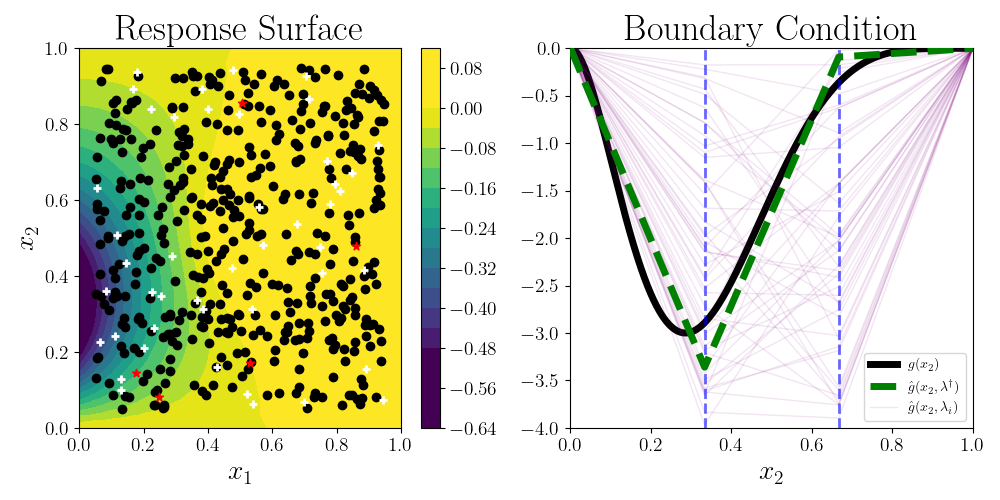

In [14]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)

# Plot respone surface from solving Eq. 30.
# u stores the mesh and values as solved by fenics
mesh, vals = raw_data["u"]
tcf = ax.tricontourf(mesh[:, 0], mesh[:, 1], vals, levels=20, vmin=-0.5, vmax=0)
fig.colorbar(tcf)

# Plot points used for each ordering
poisson_prob.sensor_scatter_plot(ax=ax, mask=order[50:500], color="k")
poisson_prob.sensor_scatter_plot(ax=ax, mask=order[5:50], marker="+", color="white")
poisson_prob.sensor_scatter_plot(ax=ax, mask=order[0:5], marker="*", color="r")

figs["sensors"] = fig

# Label and format figure
_ = plt.xlim(0, 1)
_ = plt.ylim(0, 1)
_ = plt.title(f"Response Surface")
_ = plt.xlabel("$x_1$")
_ = plt.ylabel("$x_2$")


ax = fig.add_subplot(1, 2, 2)

# Plot closest solution in sample set to the reference solution
plot_solution_spline(
    closest,
    ax=ax,
    lw=5,
    c="green",
    ls="--",
    label="$\\hat{g}(\lambda^\dagger)$",
    zorder=50,
)

# Plot first 100 lambda initial
for i, lam in enumerate(poisson_prob.lam[0:50]):
    plot_solution_spline(
        lam,
        plot_true=False,
        ax=ax,
        lw=1,
        c="purple",
        alpha=0.1,
    )

plot_vert_line(ax, 1 / 3.0, color="b", linestyle="--", alpha=0.6)
plot_vert_line(ax, 2 / 3.0, color="b", linestyle="--", alpha=0.6)

ax.set_title("Boundary Condition")
ax.set_ylabel("")
ax.legend(["$g(x_2)$", "$\\hat{g}(x_2,\lambda^\dagger)$", "$\\hat{g}(x_2,\lambda_i)$"])

fig.tight_layout()

save_figure(
    "response_surface", ".", close_fig=False, dpi=resolution, bbox_inches="tight"
)

In red we see the first 5 sensors selected. In blue the additional 45 sensors to make up the 50 sensors used for the second case. And finally for the last case we use all sensors (red, blue and black). 

## Solving MUD Problem

In [15]:
num_components = 2
mud_prob = poisson_prob.mud_problem(method="pca", num_components=num_components)
mud_pt = mud_prob.estimate()
mud_pt, mud_prob.exp_r()

(array([-3.1676855, -0.4878709]), 0.9494546646200168)

## Visualizing Learned QoI

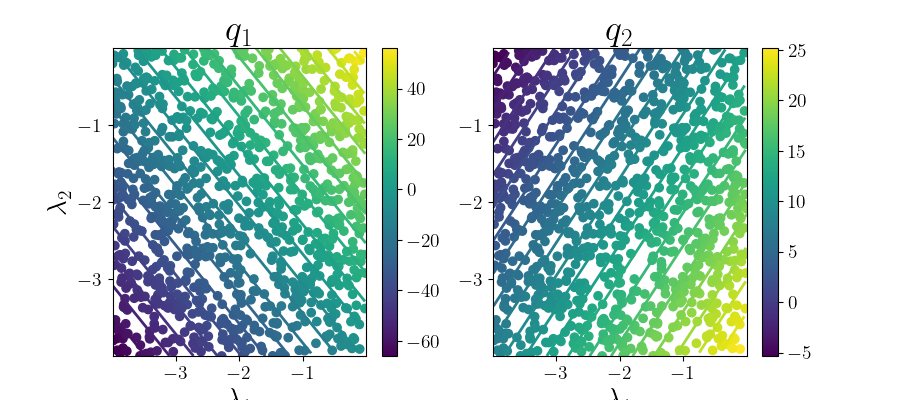

In [16]:
fig = plt.figure(figsize=(9, 4))

for i in range(num_components):
    ax = fig.add_subplot(1, 2, i + 1)
    mud_prob.plot_params_2d(ax=ax, y=i, contours=True, colorbar=True)
    if i == 1:
        ax.set_ylabel("")

save_figure("learned_qoi", ".", close_fig=False, dpi=resolution, bbox_inches="tight")

## Running Trials for increasing N

Let's get an arbitrary ordering, we've selected this one for illustrative purposes (hence fixed seed). 

We'll use 5, 50, and 500 sensors successively. Let's see which ones have been chosen according to this order.

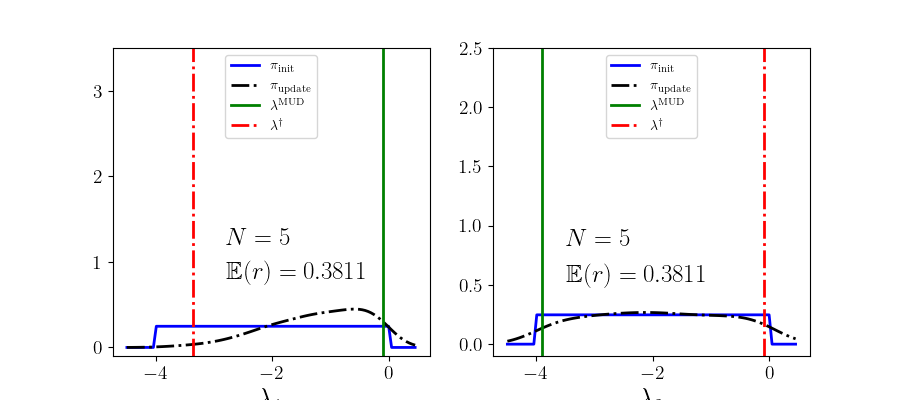

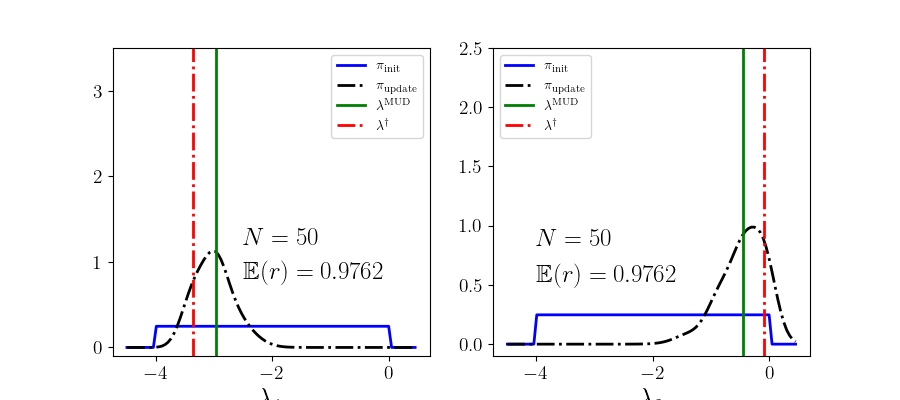

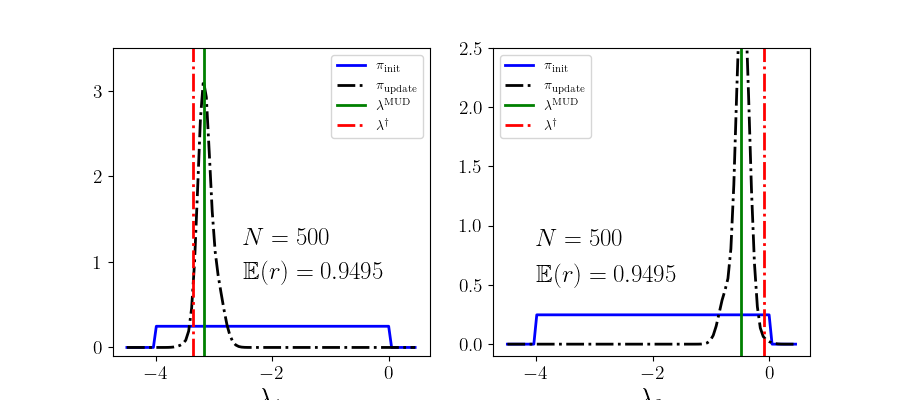

In [17]:
# N = 5
fig = plt.figure(figsize=(9, 4))

x_range = np.array([[-4.5, 0.5], [-4.5, 0.50]])
ylim1 = [-0.1, 3.5]
ylim2 = [-0.1, 2.5]

ax = fig.add_subplot(1, 2, 1)

# Solve Mud Problem for N=5 first sensors
mud_prob_5 = poisson_prob.mud_problem(
    method="pca", num_components=2, sensors_idx=order[0:5]
)
_ = mud_prob_5.estimate()

# Plot Lambda 1
mud_prob_5.plot_param_space(
    ax=ax, x_range=x_range, param_idx=0, mud_opts=None, true_opts=None
)
ax.set_ylim(ylim1)
mud_prob_5.plot_param_space(ax=ax, true_val=closest, in_opts=None, up_opts=None)
ax.set_xlabel("$\lambda_1$")
ax.text(-2.8, 1.2, f"$N = 5$", fontsize=18)
ax.text(-2.8, 0.8, f"$\mathbb{{E}}(r) = {mud_prob_5.exp_r():0.4}$", fontsize=18)
ax.legend()

# Plot Lambda 2
ax = fig.add_subplot(1, 2, 2)
mud_prob_5.plot_param_space(
    ax=ax,
    x_range=x_range,
    param_idx=1,
    mud_opts=None,
    true_opts=None,
)
ax.set_ylim(ylim2)
mud_prob_5.plot_param_space(
    ax=ax, param_idx=1, true_val=closest, in_opts=None, up_opts=None
)
ax.set_xlabel("$\lambda_2$")
ax.text(-3.5, 0.83, f"$N = 5$", fontsize=18)
ax.text(-3.5, 0.53, f"$\mathbb{{E}}(r) = {mud_prob_5.exp_r():0.4}$", fontsize=18)
ax.legend()

save_figure("solution_n5", ".", close_fig=False, dpi=resolution, bbox_inches="tight")

# N = 50
fig = plt.figure(figsize=(9, 4))

# Construct and Solve MUD Problem using first 50 sensors
mud_prob_50 = poisson_prob.mud_problem(
    method="pca", num_components=2, sensors_idx=order[0:50]
)
mud_prob_50.estimate(), mud_prob_50.exp_r()


# Plot Lambda 1
ax = fig.add_subplot(1, 2, 1)
mud_prob_50.plot_param_space(
    ax=ax,
    x_range=x_range,
    param_idx=0,
    mud_opts=None,
    true_opts=None,
)
ax.set_xlabel("$\lambda_1$")
ax.set_ylim(ylim1)
mud_prob_50.plot_param_space(ax=ax, true_val=closest, in_opts=None, up_opts=None)
ax.set_xlabel("$\lambda_1$")
ax.text(-2.5, 1.2, f"$N = 50$", fontsize=18)
ax.text(-2.5, 0.8, f"$\mathbb{{E}}(r) = {mud_prob_50.exp_r():0.4}$", fontsize=18)
ax.legend()

# Plot Lambda 2
ax = fig.add_subplot(1, 2, 2)
mud_prob_50.plot_param_space(
    ax=ax,
    x_range=x_range,
    param_idx=1,
    mud_opts=None,
    true_opts=None,
)
ax.set_ylim(ylim2)
mud_prob_50.plot_param_space(
    ax=ax, param_idx=1, true_val=closest, in_opts=None, up_opts=None
)
ax.set_xlabel("$\lambda_2$")
ax.text(-4, 0.83, f"$N = 50$", fontsize=18)
ax.text(-4, 0.53, f"$\mathbb{{E}}(r) = {mud_prob_50.exp_r():0.4}$", fontsize=18)
ax.legend()

save_figure("solution_n50", ".", close_fig=False, dpi=resolution, bbox_inches="tight")

# N = 500
fig = plt.figure(figsize=(9, 4))

mud_prob_500 = poisson_prob.mud_problem(
    method="pca", num_components=2, sensors_idx=order[0:500]
)
mud_prob_500.estimate(), mud_prob_500.exp_r()

# Plot Lambda 1
ax = fig.add_subplot(1, 2, 1)
mud_prob_500.plot_param_space(
    ax=ax,
    x_range=x_range,
    param_idx=0,
    mud_opts=None,
    true_opts=None,
)
ax.set_ylim(ylim1)
mud_prob_500.plot_param_space(ax=ax, true_val=closest, in_opts=None, up_opts=None)
ax.set_xlabel("$\lambda_1$")
ax.text(-2.5, 1.2, f"$N = 500$", fontsize=18)
ax.text(-2.5, 0.8, f"$\mathbb{{E}}(r) = {mud_prob_500.exp_r():0.4}$", fontsize=18)
ax.legend()

ax = fig.add_subplot(1, 2, 2)
mud_prob_500.plot_param_space(
    ax=ax,
    x_range=x_range,
    param_idx=1,
    mud_opts=None,
    true_opts=None,
)
ax.set_ylim(ylim2)
mud_prob_500.plot_param_space(
    ax=ax, param_idx=1, true_val=closest, in_opts=None, up_opts=None
)
ax.set_xlabel("$\lambda_2$")
ax.text(-4, 0.83, f"$N = 500$", fontsize=18)
ax.text(-4, 0.53, f"$\mathbb{{E}}(r) = {mud_prob_500.exp_r():0.4}$", fontsize=18)
ax.legend()

save_figure("solution_n500", ".", close_fig=False, dpi=resolution, bbox_inches="tight")

### Observations:

- N = 5
  - We can get a decent MUD pt estimate with as little as 5 sensors
  - Variance in these mud points is very high
  - Diagnostic is very low in most cases.
  - In particular case of five sensors chosen, can estimate first parameter decently but not second one. 
  - This makes sense since locations of two of the sensors are near the location of the knot that is controlled by $\lambda_1$ parameter, but very few sensors near location on boundary where $\lambda_2$ lies.
- N = 50
  - With $N = 50$ sensors we definitely start to get a more even sampling of the relevant areas of the response (along with a lot of sensors in non-important areas to the right of the grid). 
  - We note how the PCA solution isn't affected by including these random noisy sensors that exhibit no response to the solution surface. 
  - Furthermore we reduce variance really well in both parameter values.
  - Diagnostic is still low -> We don't have confidence in the distributions we are constructing yet because we don't have enough data to capture all observed values (more sensors would allow us to predict better observations, thus improving the diagnostic). 
 - N = 500
  - At five-hundred sensors, we nail the best possible approximation to $\lambda$ from our sample set
  - distributions peak well around both values.
  - Confidence in the quality of our distributions from our diagnostic value.

# APPENDICES

Figures that ended up being omitted

## Visualizing PCA Components

Here we explore the $Q_{PCA}$ map we construct by seeing:

1. How the first two principal components that were used look in relation to how sensor data is weighted

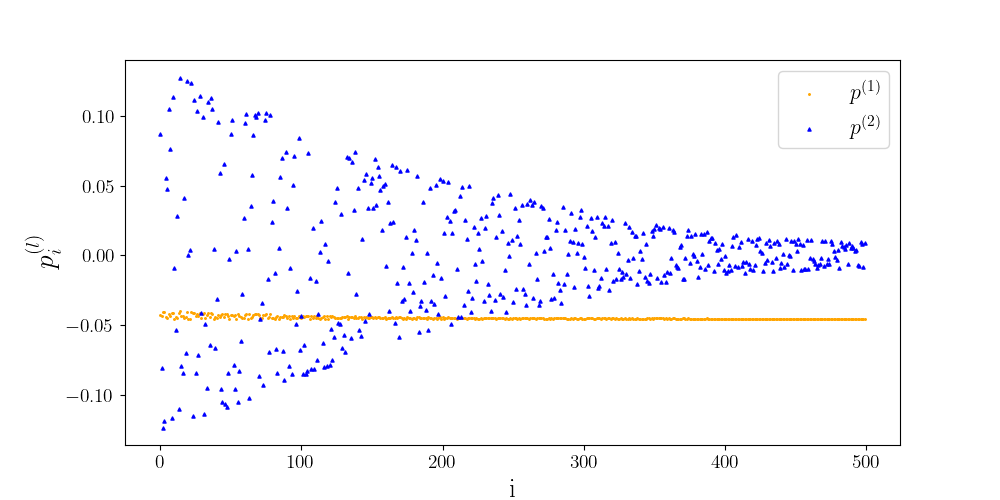

In [22]:
fig = plt.figure(figsize=(10, 5))

# PCA contours for each sample in new space
ax = fig.add_subplot(1, 1, 1)
_ = poisson_prob.mud_problem(method="pca", num_components=num_components)
# plot_1D_vecs([poisson_prob.pca["vecs"][0]], color='orange', markers=["."], ax=ax, s=5)
# plot_1D_vecs([poisson_prob.pca["vecs"][1]], color='blue', markers=["^"], ax=ax, s=5)
_ = poisson_prob.mud_problem(
    method="pca", num_components=num_components, sensors_idx=sorted_order
)
plot_1D_vecs([poisson_prob.pca["vecs"][0]], color="orange", markers=["."], ax=ax, s=5)
plot_1D_vecs([poisson_prob.pca["vecs"][1]], color="blue", markers=["^"], ax=ax, s=5)

ax.legend(["$p^{(1)}$", "$p^{{(2)}}$"])

# ax.legend(['$p^{(1)}$', '$p^{{(2)}}$',
#            '$\\tilde{p}^{{(1)}}$', '$\\tilde{p}^{{(2)}}$'],
#           loc='lower right')
#
save_figure(
    "pca_vectors_ordered", ".", close_fig=False, dpi=resolution, bbox_inches="tight"
)

# Get lims from this pont to set colorbar for contour plots
lims = ax.get_ylim()

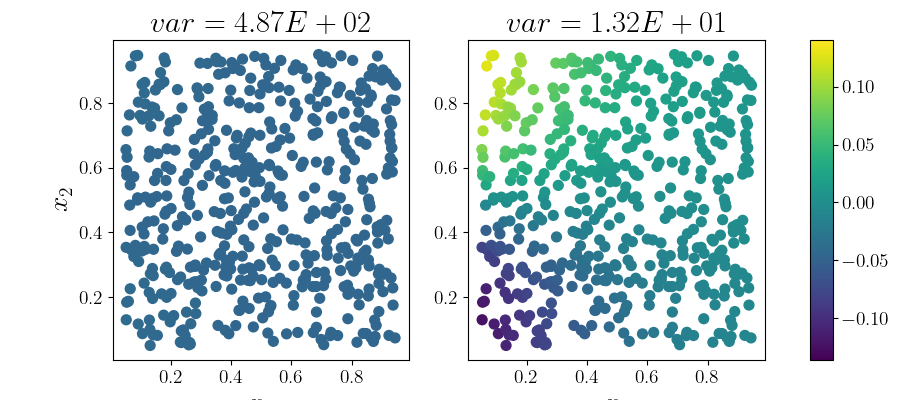

In [23]:
fig = plt.figure(figsize=(9, 4))

contour = False
# note we could use ordered or unordered here, results won't change
_ = poisson_prob.mud_problem(
    method="pca", num_components=num_components, sensors_mask=sorted_order
)
for i, v in enumerate(poisson_prob.pca["vecs"]):
    ax = fig.add_subplot(1, num_components, i + 1)
    ax = poisson_prob.sensor_scatter_plot(
        mask=sorted_order, ax=ax, c=v, colorbar=False, s=50, vmin=lims[0], vmax=lims[1]
    )
    if contour:
        poisson_prob.sensor_contour_plot(
            ax=ax,
            c_vals=v,
            fill=False,
            colorbar=False,
            levels=30,
            vmin=lims[0],
            vmax=lims[1],
        )
    ax.set_title(f"$var = {poisson_prob.pca['var'][i]:.2E}$", fontsize=22)
    ax.set_xlabel("$x_1$")
    if i == 0:
        ax.set_ylabel("$x_2$")

plt.subplots_adjust(bottom=0.1, right=0.85, top=0.9)
cax = plt.axes([0.9, 0.1, 0.025, 0.8])
plt.colorbar(cax=cax)

save_figure(
    "sensor_contours", ".", close_fig=False, dpi=resolution, bbox_inches="tight"
)

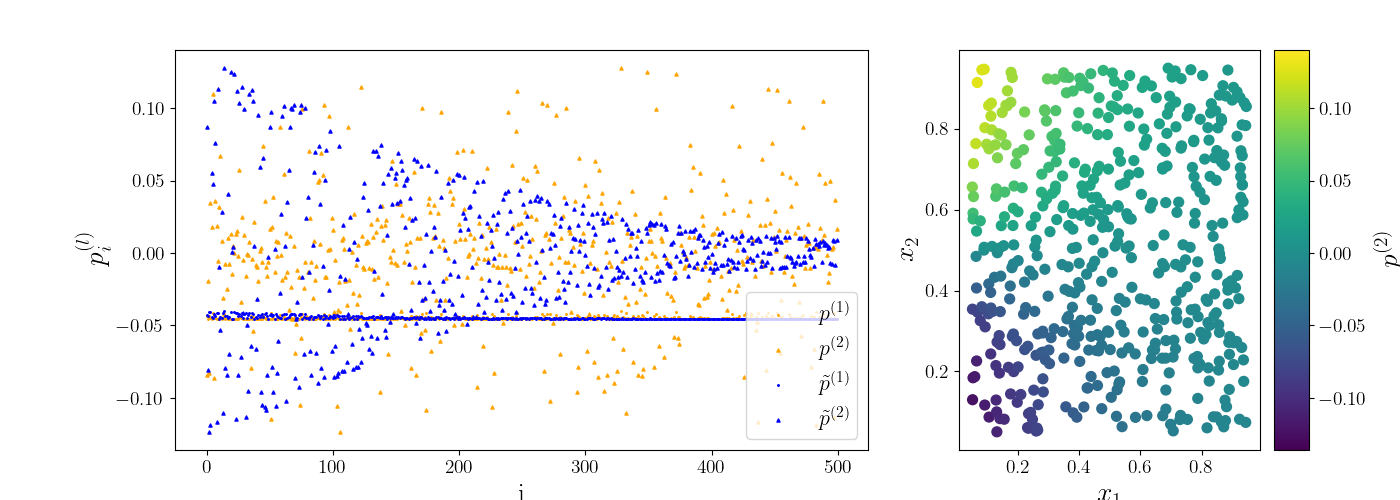

In [24]:
fig = plt.figure(figsize=(14, 5))

contour = False
# note we could use ordered or unordered here, results won't change
_ = poisson_prob.mud_problem(
    method="pca", num_components=num_components, sensors_mask=sorted_order
)

ax = fig.add_subplot(1, 3, (1, 2))
_ = poisson_prob.mud_problem(method="pca", num_components=num_components)
plot_1D_vecs([poisson_prob.pca["vecs"][0]], color="orange", markers=["."], ax=ax, s=5)
plot_1D_vecs([poisson_prob.pca["vecs"][1]], color="orange", markers=["^"], ax=ax, s=5)
_ = poisson_prob.mud_problem(
    method="pca", num_components=num_components, sensors_idx=sorted_order
)
plot_1D_vecs([poisson_prob.pca["vecs"][0]], color="blue", markers=["."], ax=ax, s=5)
plot_1D_vecs([poisson_prob.pca["vecs"][1]], color="blue", markers=["^"], ax=ax, s=5)

ax.legend(
    ["$p^{(1)}$", "$p^{{(2)}}$", "$\\tilde{p}^{{(1)}}$", "$\\tilde{p}^{{(2)}}$"],
    loc="lower right",
)

# Get lims from this pont to set colorbar for contour plots
lims = ax.get_ylim()

ax = fig.add_subplot(1, 3, 3)
ax = poisson_prob.sensor_scatter_plot(
    mask=sorted_order,
    ax=ax,
    c=poisson_prob.pca["vecs"][1],
    colorbar=False,
    s=50,
    vmin=lims[0],
    vmax=lims[1],
)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

plt.subplots_adjust(bottom=0.1, right=0.90, top=0.9, wspace=0.3)
cax = plt.axes([0.91, 0.1, 0.025, 0.8])
cbar = plt.colorbar(cax=cax)
cbar.set_label("$p^{(2)}$")

save_figure("pca_vecs", ".", close_fig=False, dpi=resolution, bbox_inches="tight")

## Visualizing Solution Splines and Variance in MUD Solutions

Now lets see how these estimates themselves vary over different realizations of noisy data.

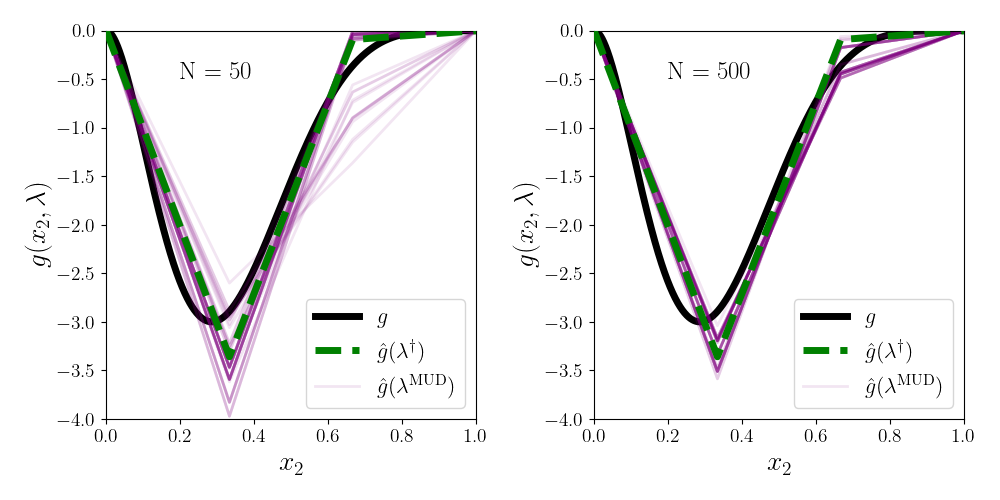

In [25]:
num_trials = 50

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1)
num_sensors = 50
plot_solution_spline(
    closest,
    ax=ax,
    lw=5,
    c="green",
    ls="--",
    zorder=50,
)

for i in range(num_trials):
    poisson_prob.measurements_from_reference(std_dev=0.05)
    mud_prob = poisson_prob.mud_problem(
        method="pca", num_components=2, sensors_idx=order[0:num_sensors]
    )
    mud_pt = mud_prob.estimate()
    ax = plot_solution_spline(
        mud_pt,
        plot_true=False,
        ax=ax,
        label="$\lambda_\\text{MUD}$",
        color="purple",
        alpha=0.1,
    )
ax.text(0.2, -0.5, f"N = {num_sensors}", fontsize=18)
ax.legend(["$g$", "$\\hat{g}(\lambda^\dagger)$", "$\\hat{g}(\lambda^\\text{MUD})$"])


ax = fig.add_subplot(1, 2, 2)
num_sensors = 500
plot_solution_spline(
    closest,
    ax=ax,
    lw=5,
    c="green",
    ls="--",
    zorder=50,
)
for i in range(num_trials):
    poisson_prob.measurements_from_reference(std_dev=0.05)
    mud_prob = poisson_prob.mud_problem(
        method="pca", num_components=2, sensors_idx=order[0:num_sensors]
    )
    mud_pt = mud_prob.estimate()
    ax = plot_solution_spline(
        mud_pt,
        plot_true=False,
        ax=ax,
        label="$\lambda_\\text{MUD}$",
        color="purple",
        alpha=0.1,
    )
ax.text(0.2, -0.5, f"N = {num_sensors}", fontsize=18)
ax.legend(["$g$", "$\\hat{g}(\lambda^\dagger)$", "$\\hat{g}(\lambda^\\text{MUD})$"])
_ = fig.tight_layout()

save_figure("pde_mud_variance", save_dir, close_fig=False, dpi=500, bbox_inches="tight")

## 4D Problem

In [47]:
df = "poisson_datasets/s1000_n100_d4_res-2022_08_02-03_00_52_PM"
ord_df = df + "_ordered"

In [48]:
raw_data, poisson_prob = load_poisson_prob(df, std_dev=0.05, seed=11)

In [49]:
num_components = 4
mud_prob = poisson_prob.mud_problem(method="pca", num_components=num_components)
mud_pt = mud_prob.estimate()
mud_pt, mud_prob.exp_r()

(array([-2.48941094, -2.75397626, -0.69691531, -0.34255572]),
 0.9596846280177243)

### PCA Components

Here we explore the $Q_{PCA}$ map we construct by seeing:

1. How the first four principal components that were used look in relation to how sensor data is weighted

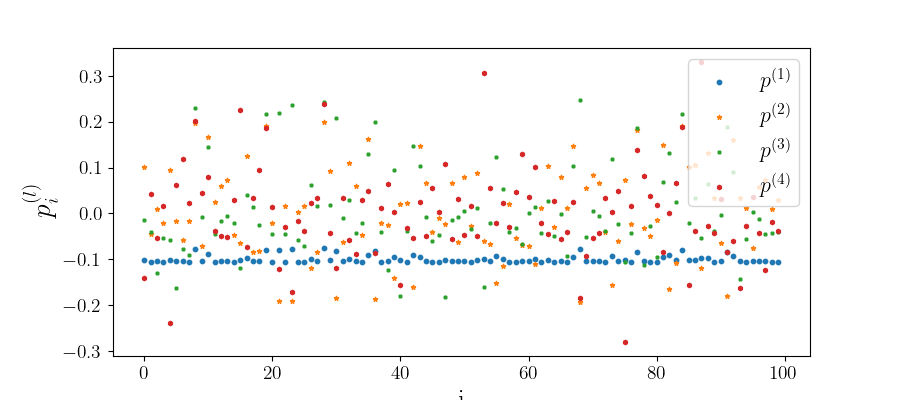

In [50]:
fig = plt.figure(figsize=(9, 4))

# PCA contours for each sample in new space
num_rows = 2
ax = fig.add_subplot(1, num_components, (1, num_components))
plot_1D_vecs(poisson_prob.pca["vecs"], markers=["o", "*", "+", "h"], ax=ax, s=10)
lims = ax.get_ylim()

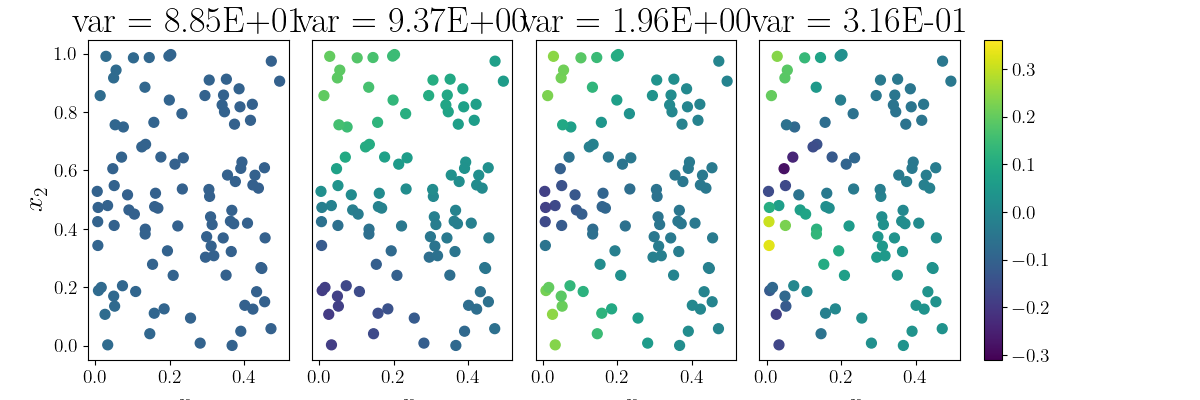

In [41]:
fig = plt.figure(figsize=(12, 4))

contour = False
for i, v in enumerate(poisson_prob.pca["vecs"]):
    ax = fig.add_subplot(1, num_components, i + 1)
    ax = poisson_prob.sensor_scatter_plot(
        ax=ax, c=v, colorbar=False, s=50, vmin=lims[0], vmax=lims[1]
    )
    if contour:
        poisson_prob.sensor_contour_plot(
            ax=ax,
            c_vals=v,
            fill=False,
            colorbar=False,
            levels=30,
            vmin=lims[0],
            vmax=lims[1],
        )
    ax.set_title(f"var = {poisson_prob.pca['var'][i]:.2E}")
    if i == 0:
        ax.set_ylabel("$x_2$")
    if i != 0:
        ax.get_yaxis().set_visible(False)
    ax.set_xlabel("$x_1$")

fig.tight_layout()

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.82, 0.1, 0.015, 0.8])
plt.colorbar(cax=cax)

#### Ordering Sensors

In [42]:
raw_data.keys()
import numpy as np

ind = np.lexsort((raw_data["sensors"][:, 1], raw_data["sensors"][:, 0]))

In [33]:
ordered_data = {}
ordered_data["lam"] = raw_data["lam"]
ordered_data["domain"] = raw_data["domain"]
ordered_data["u"] = raw_data["u"]
ordered_data["true_vals"] = np.array(raw_data["true_vals"])[ind]
ordered_data["sensors"] = np.array(raw_data["sensors"])[ind]
ordered_data["data"] = np.array(raw_data["data"])[:, ind]

In [34]:
ord_df = df + "_ordered"
with open(ord_df, "wb") as fp:
    pickle.dump(ordered_data, fp)
ord_df

NameError: name 'pickle' is not defined

### Plotting sensors for ordered DS

In [46]:
raw_data, poisson_prob = load_poisson_prob(ord_df, std_dev=0.05, seed=11)
num_components = 4
mud_prob = poisson_prob.mud_problem(method="pca", num_components=num_components)
mud_pt = mud_prob.estimate()
mud_pt, mud_prob.exp_r()

EOFError: Ran out of input

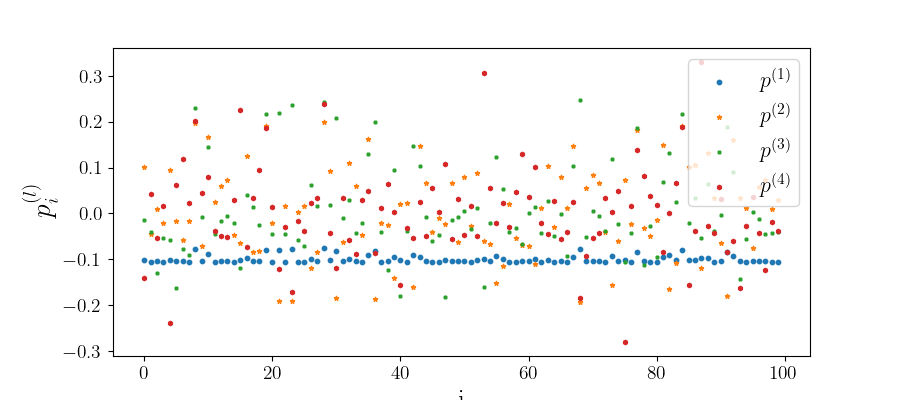

In [45]:
fig = plt.figure(figsize=(9, 4))

# PCA contours for each sample in new space
num_rows = 2
ax = fig.add_subplot(1, num_components, (1, num_components))
plot_1D_vecs(poisson_prob.pca["vecs"], markers=["o", "*", "+", "h"], ax=ax, s=10)
lims = ax.get_ylim()

## 10d

In [22]:
df = "s10000_n500_d10_res-2022_08_03-07_09_47_AM"
raw_data, poisson_prob = load_poisson_prob(df, std_dev=0.05, seed=11)

In [27]:
num_components = 10
mud_prob = poisson_prob.mud_problem(method="pca", num_components=num_components)
mud_pt = mud_prob.estimate()
mud_pt, mud_prob.exp_r()

(array([-1.09074888, -3.47182676, -1.87885011, -3.42147984, -1.25077792,
        -0.71005043, -0.06771428, -1.00435541, -0.25712508, -1.34443575]),
 2.6072400456961117e-07)

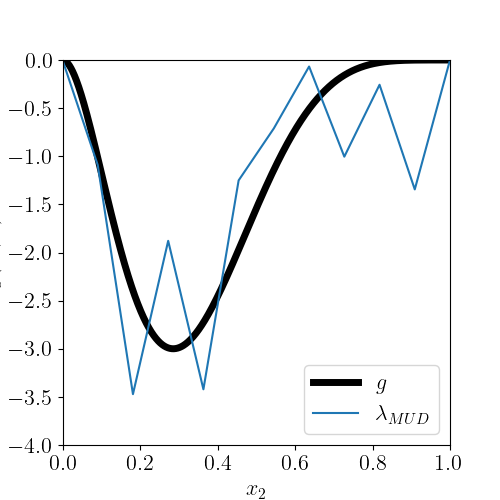

In [28]:
ax = plot_solution_spline(mud_pt, label="$\lambda_{MUD}$")
ax.legend()